In [6]:
import os
import cv2

# Define the new dataset path
dataset_path = "maizeDataset"

# Define class names
categories = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
]

# Count images per class
class_counts = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    class_counts[category] = len(os.listdir(category_path))

# Print class distributions
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Get image size dynamically from first image
for category in categories:
    category_path = os.path.join(dataset_path, category)
    first_image = next(iter(os.listdir(category_path)), None)

    if first_image:
        img_path = os.path.join(category_path, first_image)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, channels = img.shape
            print(f"Image size: {width}x{height}, Channels: {channels}")
            break  # Only need one image to determine size

# Define image size dynamically
IMG_SIZE = (width, height)
print(f"Using Image Size: {IMG_SIZE}")


Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___healthy: 1162 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Image size: 256x256, Channels: 3
Using Image Size: (256, 256)


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  # 80% training, 20% validation
)

# Load training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # Multi-class classification
    subset="training",
    shuffle=True, 
    classes= ["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"]
)

# Load validation data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # Multi-class classification
    subset="validation",
    shuffle=True, 
    classes= ["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"]
)

# Print class mapping
print("Class indices:", train_generator.class_indices)


Found 3083 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Class indices: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0, 'Corn_(maize)___Common_rust_': 1, 'Corn_(maize)___healthy': 2, 'Corn_(maize)___Northern_Leaf_Blight': 3}


In [8]:
from sklearn.utils import class_weight
import numpy as np

# Convert class counts to class weights
labels = []
for i, category in enumerate(categories):
    labels.extend([i] * class_counts[category])  # Assign label numbers (0,1,2,3)

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 1.8771929824561404, 1: 0.8078859060402684, 2: 0.8287435456110155, 3: 0.9776649746192894}


In [9]:
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(4, activation='softmax')  # 4 classes → Use softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Multi-class loss
              metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

In [10]:
import time 
start_time = time.time()  

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15, 
    class_weight=class_weights_dict  # Balance class distribution
) 

end_time = time.time() 
total_time = end_time - start_time 
print(f"\nTotal Training time: {total_time:.2f} seconds. {total_time/60:.2f} minutes")


Epoch 1/15
97/97 [==============================] - 87s 884ms/step - loss: 0.8824 - accuracy: 0.6597 - val_loss: 0.3182 - val_accuracy: 0.8739
Epoch 2/15
97/97 [==============================] - 88s 903ms/step - loss: 0.4778 - accuracy: 0.8138 - val_loss: 0.2523 - val_accuracy: 0.8843
Epoch 3/15
97/97 [==============================] - 82s 847ms/step - loss: 0.4060 - accuracy: 0.8508 - val_loss: 0.2735 - val_accuracy: 0.8882
Epoch 4/15
97/97 [==============================] - 82s 846ms/step - loss: 0.3663 - accuracy: 0.8550 - val_loss: 0.3140 - val_accuracy: 0.8010
Epoch 5/15
97/97 [==============================] - 82s 847ms/step - loss: 0.3205 - accuracy: 0.8874 - val_loss: 0.2049 - val_accuracy: 0.9129
Epoch 6/15
97/97 [==============================] - 83s 858ms/step - loss: 0.2821 - accuracy: 0.9033 - val_loss: 0.1692 - val_accuracy: 0.9272
Epoch 7/15
97/97 [==============================] - 82s 843ms/step - loss: 0.2458 - accuracy: 0.9173 - val_loss: 0.2162 - val_accuracy: 0.9090

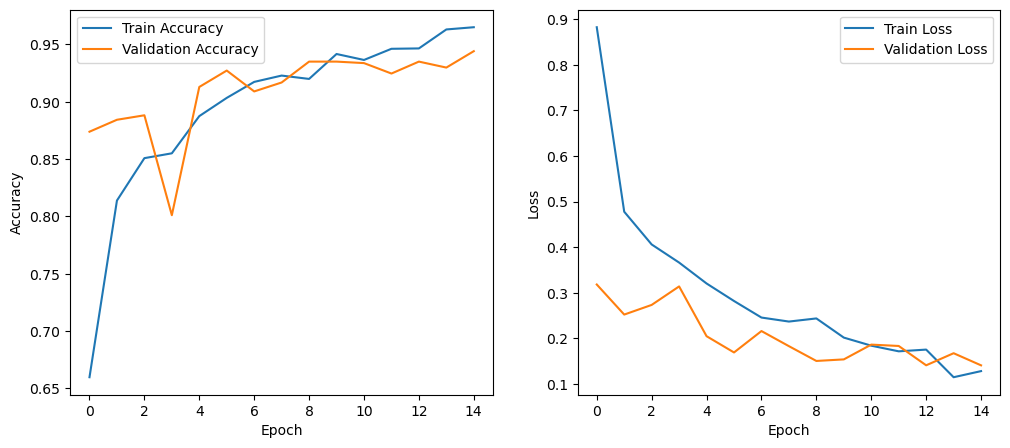

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [22]:
import random
import os 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image 

# Base directory where split data is stored
base_dir = "maizeDataset"

# Available categories  # Training and validation sets
categories = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
]

def get_random_image():
    """Selects a random image from one of the four datasets and returns its full path."""
     
    category = random.choice(categories)  
    
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    if not images:
        return None 
    random_image = random.choice(images)
    return os.path.join(category_path, random_image), category

# Function to predict an image and display results
def predict_image(img_path, category):
    img_name = os.path.basename(img_path)  # Extract image name

    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions

    # Make prediction
    prediction = model.predict(img_array)[0] # Get single prediction value

    class_index = np.argmax(prediction)  # Get the class with highest probability
    class_label = list(train_generator.class_indices.keys())[class_index]

    # Print results
    print(f"Image: {img_name}")
    print(f" Confidence: {prediction[class_index]:.4f} \n Predicted Class: {class_label} \n Actual Class   : {category}")

    # Show the image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{img_name}\n{class_label} ({prediction[class_index]:.4f})")
    plt.show()



1/1 [==============================] - 0s 31ms/step
Image: d9d2f7df-7161-4d20-b0ee-48f8dc8683de___RS_GLSp 9313.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


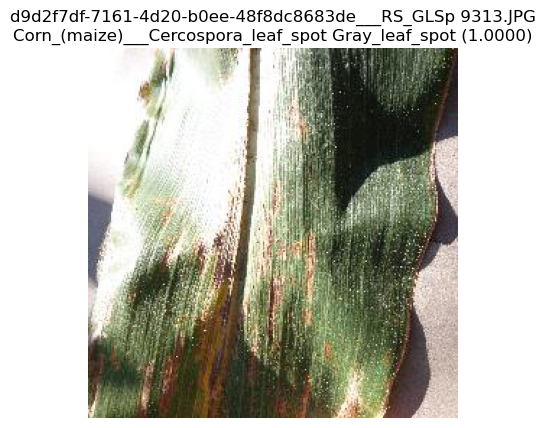

1/1 [==============================] - 0s 27ms/step
Image: d9d14fdf-8f10-4023-8caf-c6ed6fd77b0f___RS_NLB 4003.JPG
 Confidence: 0.7349 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


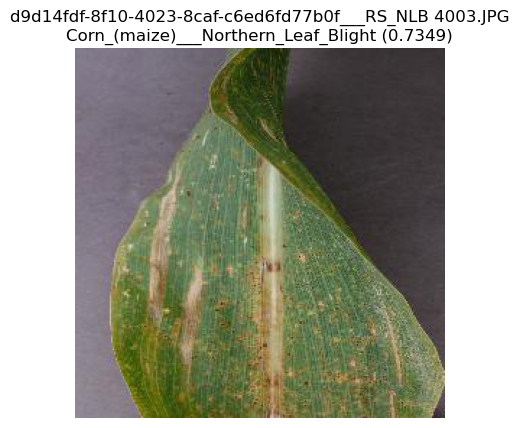

1/1 [==============================] - 0s 24ms/step
Image: 59633534-1c22-49c5-a8c8-909653945bf7___R.S_HL 7912 copy 2.jpg
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


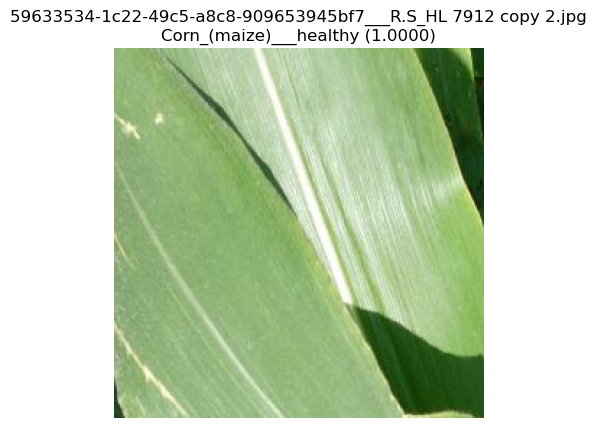

1/1 [==============================] - 0s 28ms/step
Image: 4810995d-308d-4931-9b96-1021194e596e___R.S_HL 8258 copy.jpg
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


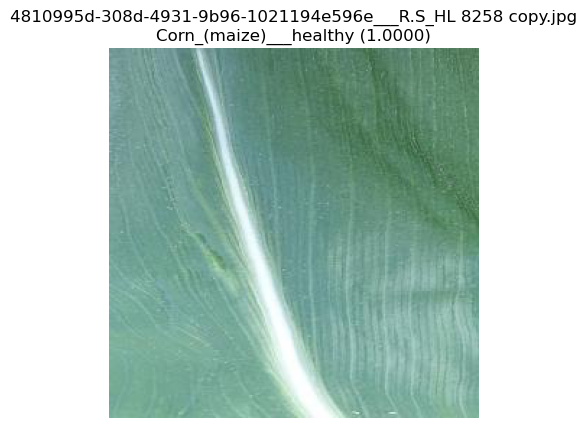

1/1 [==============================] - 0s 27ms/step
Image: RS_Rust 1681.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


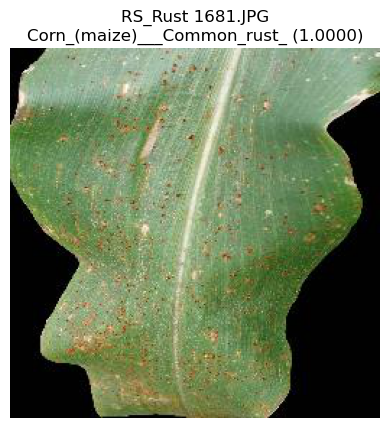

1/1 [==============================] - 0s 36ms/step
Image: 59bc212e-6b39-4712-b9c9-6edc3fa3e05f___RS_NLB 3604 copy 2.jpg
 Confidence: 0.9990 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


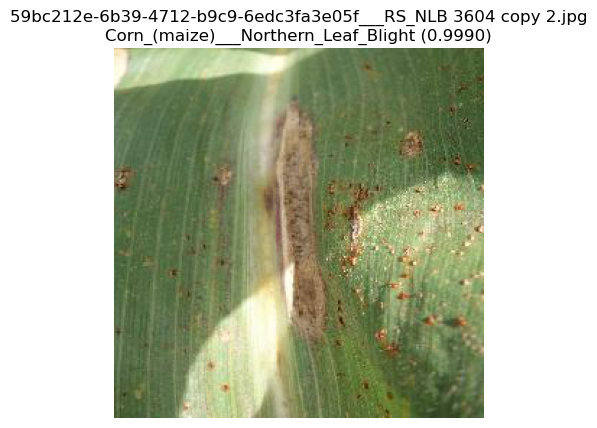

1/1 [==============================] - 0s 27ms/step
Image: 1cf6abd0-261e-4a8c-92b4-92320be88999___R.S_HL 8121 copy 2.jpg
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


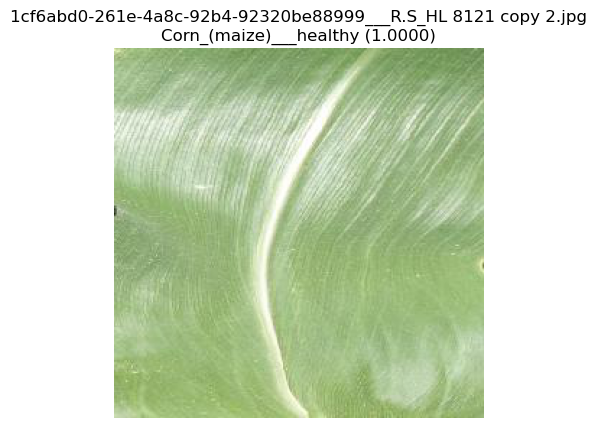

1/1 [==============================] - 0s 24ms/step
Image: b2f77b0d-b331-4fa6-81b1-fa5d56674a64___RS_NLB 4076.JPG
 Confidence: 0.9565 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


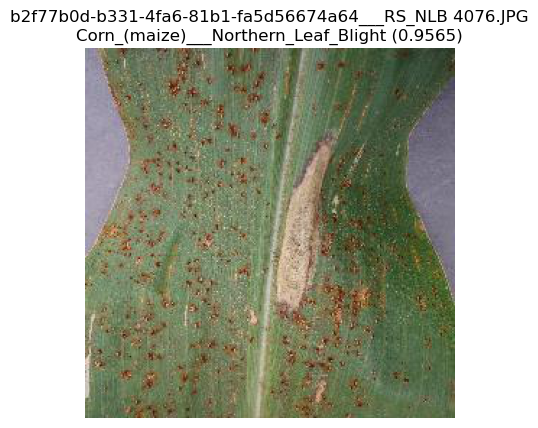

1/1 [==============================] - 0s 23ms/step
Image: RS_Rust 1775.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


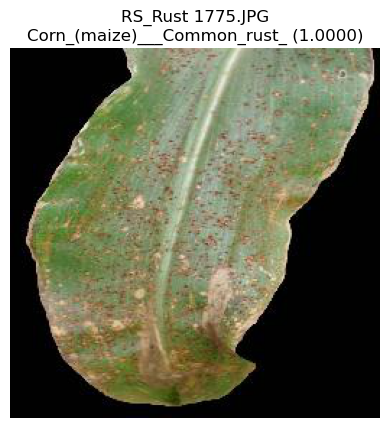

1/1 [==============================] - 0s 25ms/step
Image: 41759050-8a14-4394-9558-c74ec19a5e50___RS_GLSp 4685.JPG
 Confidence: 0.9138 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


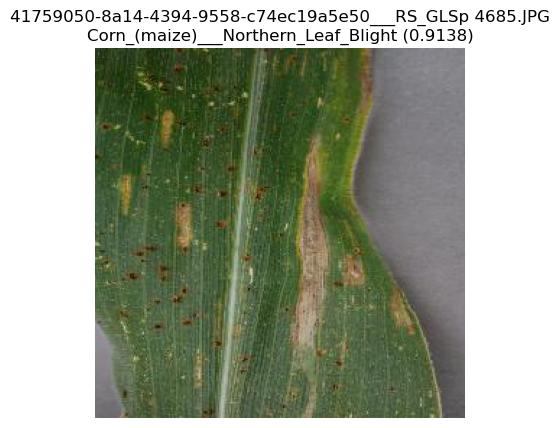

1/1 [==============================] - 0s 24ms/step
Image: 980b6d5a-da0a-4904-82f4-19987a7f635c___RS_GLSp 4559.JPG
 Confidence: 0.9976 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


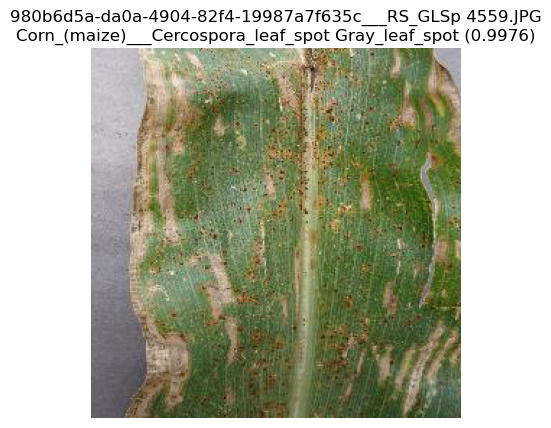

1/1 [==============================] - 0s 24ms/step
Image: dc5013d6-de04-4079-93f1-320d6b765cd3___RS_NLB 0822 copy.jpg
 Confidence: 0.9439 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


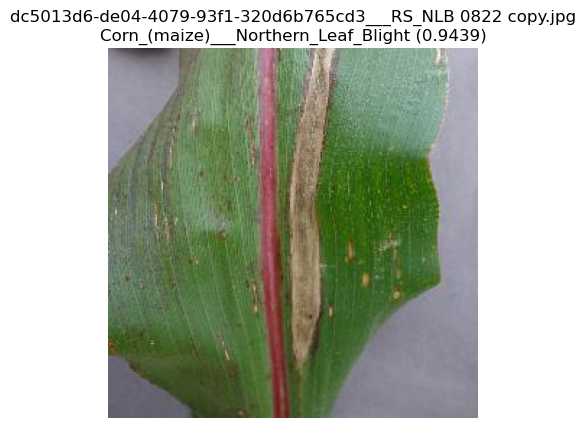

1/1 [==============================] - 0s 25ms/step
Image: c7506909-ffa6-4143-9811-f73e29854443___RS_GLSp 7318.JPG
 Confidence: 0.9982 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


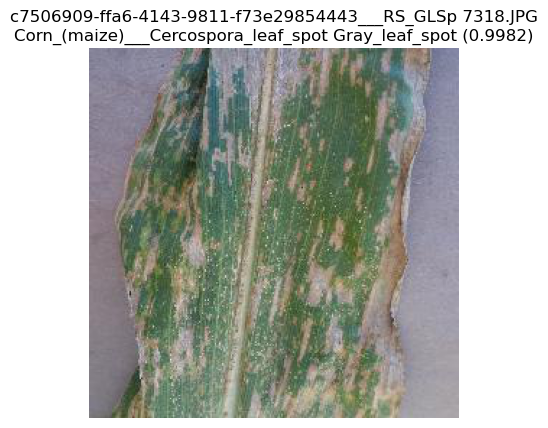

1/1 [==============================] - 0s 24ms/step
Image: f07ee21f-940b-453a-953d-00f53482b7f0___RS_NLB 4095.JPG
 Confidence: 0.9978 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


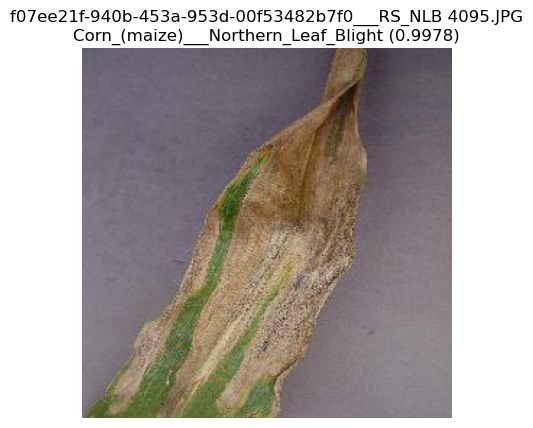

1/1 [==============================] - 0s 29ms/step
Image: cb647989-23e4-4d54-ba50-7685b19e780d___RS_GLSp 9280.JPG
 Confidence: 0.9976 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


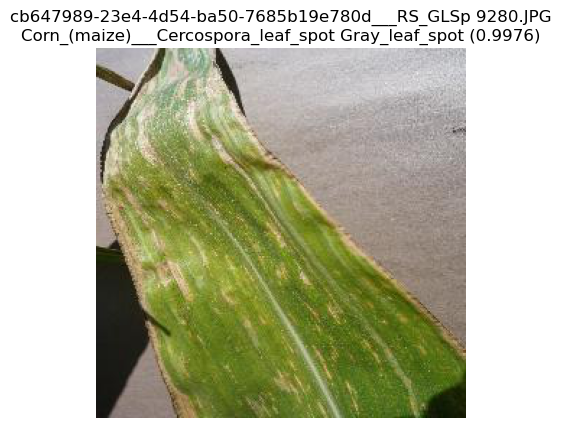

1/1 [==============================] - 0s 34ms/step
Image: cc926ea7-7824-4f6d-8c2b-837771ffdbee___RS_NLB 4142.JPG
 Confidence: 0.9973 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


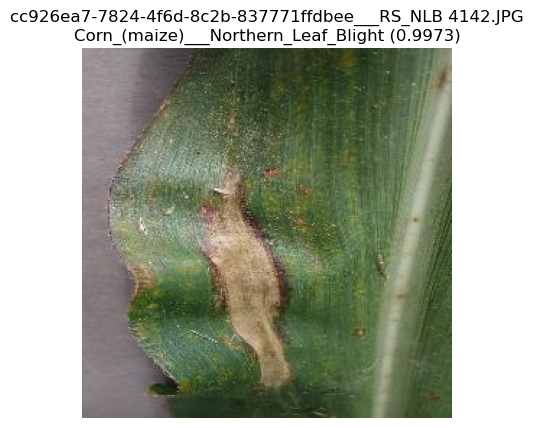

1/1 [==============================] - 0s 24ms/step
Image: d1f96a7c-c108-45a4-82f6-ffe84b0d081f___RS_GLSp 9304.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


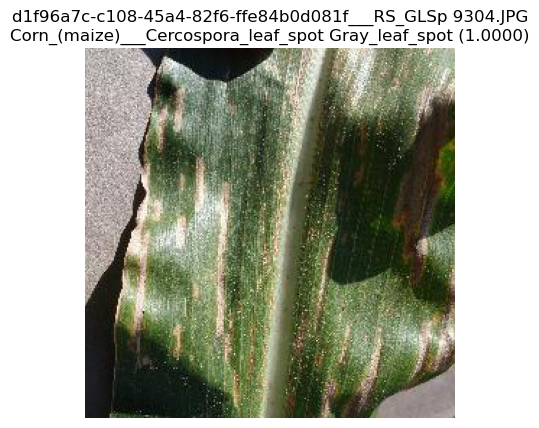

1/1 [==============================] - 0s 27ms/step
Image: RS_Rust 2622.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


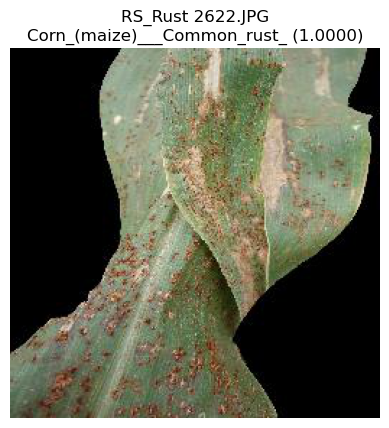

1/1 [==============================] - 0s 26ms/step
Image: 965d2fb1-0fc2-46ff-86a6-3d72c176187f___R.S_HL 5550 copy 2.jpg
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


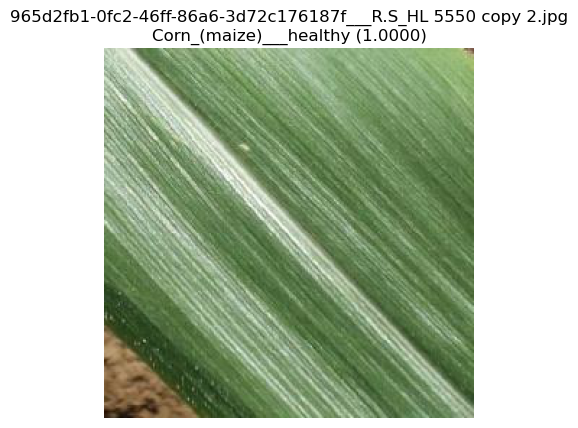

1/1 [==============================] - 0s 23ms/step
Image: 40ca043f-ee3d-4327-95ee-09d7b41ebfc4___RS_NLB 3890.JPG
 Confidence: 0.6677 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


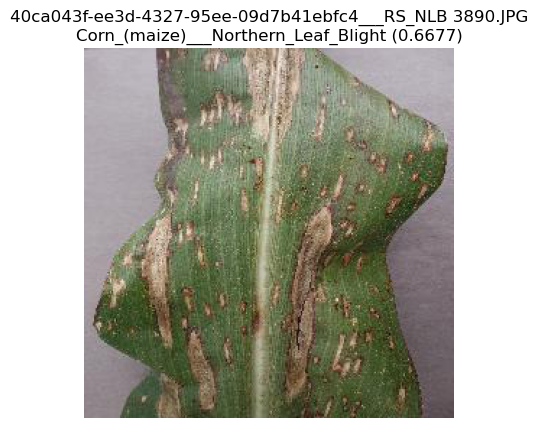

In [23]:
tests = 20
for i in range(tests):   
    rand_img, cat = get_random_image()
    predict_image(rand_img, cat)